<a href="https://colab.research.google.com/github/tops201/project_507/blob/main/507_508/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import io

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras

#from google.colab import files #for google colab

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dense, Input, Lambda, LSTM

In [9]:
#fetch dataset

#data_file = files.upload() #for google colab

#df = pd.read_excel(io.BytesIO(data_file["daily_field_data.xlsx"]), index_col="DATEPRD") #for google colab
df = pd.read_excel("daily_field_data.xlsx", index_col="DATEPRD") #for local IDE

date = df.index

df.head()

,BORE_GAS_VOL,BORE_OIL_VOL,BORE_WAT_VOL
DATEPRD,,,
2008-02-12,38888.67,284.65,385.01
2008-02-13,285246.16,1869.70,7.13
2008-02-14,509954.88,3124.09,1.16
2008-02-15,383426.67,2608.28,0.97
2008-02-16,418474.00,3051.80,4.89


In [10]:
#function to plot the a series
def plot_series(x, y, format="-", start=None, end=None, label=None):
    plt.plot(x[start:end], y[start:end], format, label=label)
    plt.xlabel("Date")
    plt.ylabel("Oil Volume")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

#clear session 
def refresh():
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

class ResetStatesCallback(Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

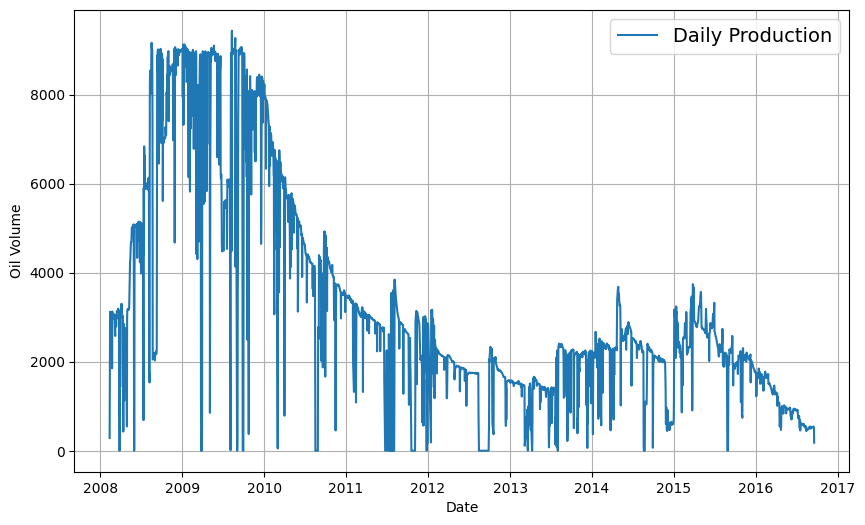

array([ 284.65, 1869.7 , 3124.09, ...,  534.87,  530.27,  180.04])

In [11]:
oil_data = df.BORE_OIL_VOL.to_numpy()
oil_cum = np.cumsum(oil_data)

plt.figure(figsize=(10, 6))
plot_series(date, oil_data, label="Daily Production")
plt.show()

oil_data

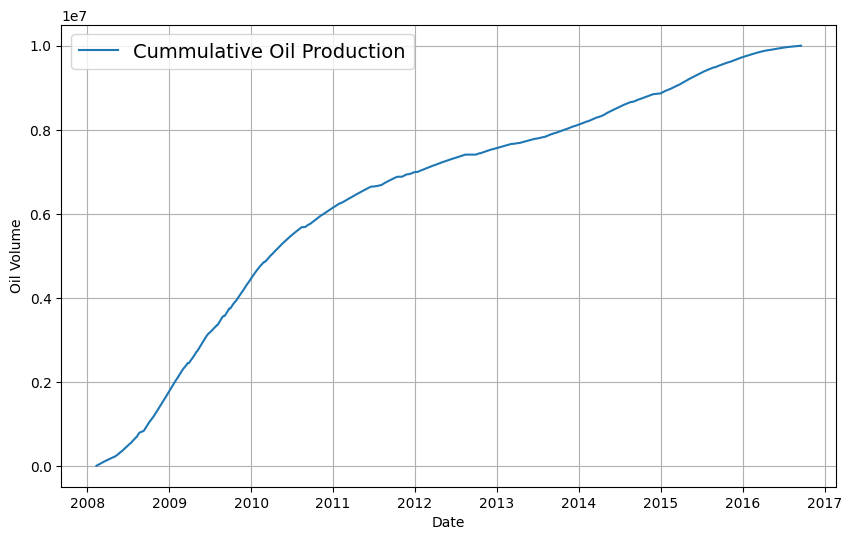

In [12]:
plt.figure(figsize=(10, 6))
plot_series(date, oil_cum, label="Cummulative Oil Production")
plt.show()

In [13]:
#split the time series into training and validation sets
split_date = 2750

date_train = date[:split_date]
date_valid = date[split_date:]

x_train = oil_data[:split_date]
x_valid = oil_data[split_date:]

print(x_train.shape, x_valid.shape, date_train.shape, date_valid.shape)

(2750,) (306,) (2750,) (306,)


# NAIVE Forecast

In [14]:
naive_forecast = oil_data[split_date - 1:-1]

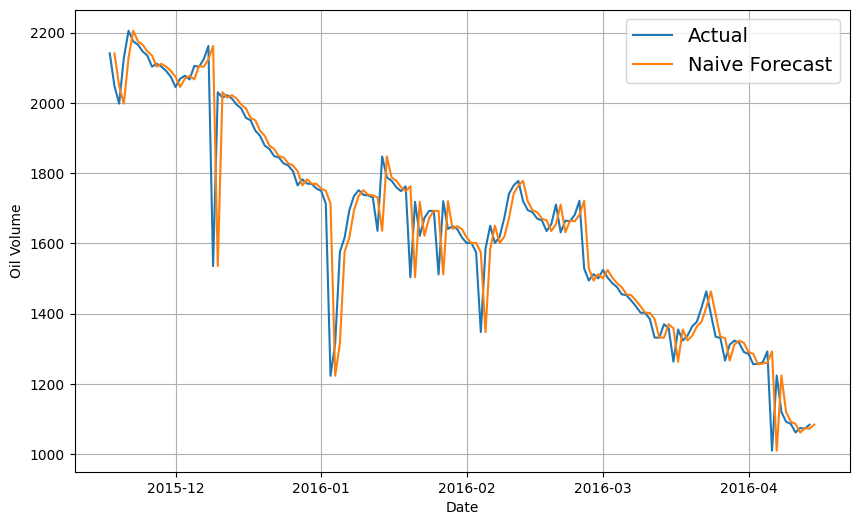

In [20]:
plt.figure(figsize=(10, 6))
plot_series(date_valid, x_valid, start=0, end=150, label="Actual")
plot_series(date_valid, naive_forecast, start=1, end=151, label="Naive Forecast")

plt.show()

In [21]:
keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

44.317647058823525

# Moving Average

In [22]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
    If window_size=1, then this is equivalent to naive forecast"""
    
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    
    return mov[window_size - 1:-1] / window_size

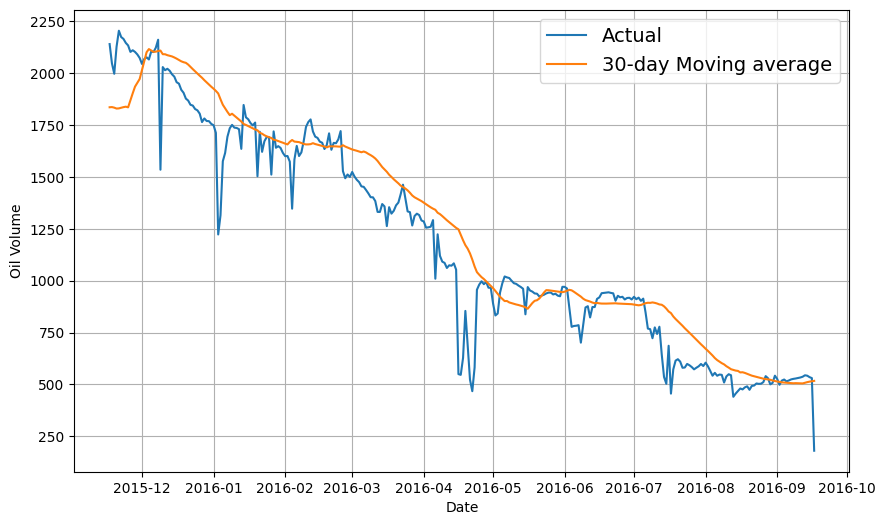

In [25]:
moving_avg = moving_average_forecast(oil_data, 30)[split_date - 30:]

plt.figure(figsize=(10, 6))
plot_series(date_valid, x_valid, label="Actual")
plot_series(date_valid, moving_avg, label="30-day Moving average")

plt.show()

In [26]:
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

115.81727015249383

# Linear Model

In [27]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [29]:
refresh()

window_size = 30

train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = Sequential([
            Dense(1, input_shape=[window_size])
        ])

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
85/85 [==============================] - 2s 10ms/step - loss: 4320.5557 - mae: 4321.0557 - val_loss: 149.5156 - val_mae: 150.0156
Epoch 2/100
85/85 [==============================] - 1s 5ms/step - loss: 3079.8464 - mae: 3080.3464 - val_loss: 176.7217 - val_mae: 177.2213
Epoch 3/100
85/85 [==============================] - 1s 5ms/step - loss: 4238.5464 - mae: 4239.0459 - val_loss: 1056.5715 - val_mae: 1057.0715
Epoch 4/100
85/85 [==============================] - 1s 5ms/step - loss: 3682.2832 - mae: 3682.7832 - val_loss: 521.1384 - val_mae: 521.6384
Epoch 5/100
85/85 [==============================] - 1s 6ms/step - loss: 3612.4551 - mae: 3612.9551 - val_loss: 770.1208 - val_mae: 770.6208
Epoch 6/100
85/85 [==============================] - 1s 7ms/step - loss: 3729.9758 - mae: 3730.4753 - val_loss: 714.4842 - val_mae: 714.9842
Epoch 7/100
85/85 [==============================] - 1s 5ms/step - loss: 3316.9089 - mae: 3317.4089 - val_loss: 338.8853 - val_mae: 339.3853
Epoch 8/10

In [30]:
refresh()

window_size = 30

train_set = window_dataset(x_train, window_size)

model = Sequential([
            Dense(1, input_shape=[window_size])
        ])

lr_schedule = LearningRateScheduler(
                lambda epoch: 1e-6 * 10**(epoch / 30)
                )

optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 1735.2896 - mae: 1735.7896
Epoch 2/100
85/85 [==============================] - 1s 4ms/step - loss: 655.3798 - mae: 655.8794
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 562.8160 - mae: 563.3156
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 518.5814 - mae: 519.0812
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 461.1843 - mae: 461.6840
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 447.2318 - mae: 447.7313
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 675.5176 - mae: 676.0173
Epoch 8/100
85/85 [==============================] - ETA: 0s - loss: 633.1204 - mae: 633.620 - 0s 3ms/step - loss: 618.6091 - mae: 619.1087
Epoch 9/100
85/85 [==============================] - 1s 4ms/step - loss: 627.7036 - mae: 628.2034
Epoch 10/100
85/85 [==============================] - 0s 3ms/step - loss: 

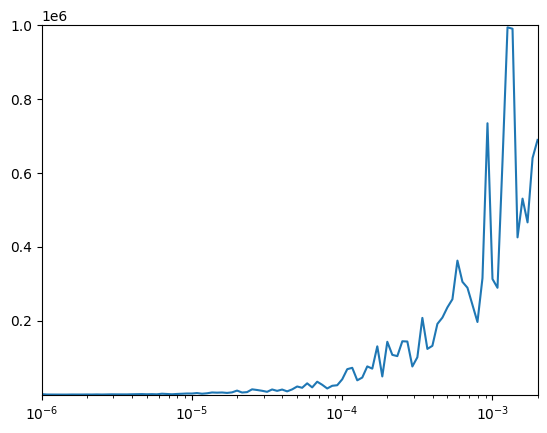

993853.25

In [36]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 2e-3, 210, 1e6])

plt.show()

max(history.history["loss"])

In [37]:
keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = Sequential([
            Dense(1, input_shape=[window_size])
        ])

optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = EarlyStopping(patience=10)

model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
85/85 [==============================] - 2s 8ms/step - loss: 1906.4274 - mae: 1906.9269 - val_loss: 111.8942 - val_mae: 112.3909
Epoch 2/500
85/85 [==============================] - 1s 5ms/step - loss: 737.2562 - mae: 737.7562 - val_loss: 84.5622 - val_mae: 85.0612
Epoch 3/500
85/85 [==============================] - 1s 5ms/step - loss: 635.3730 - mae: 635.8729 - val_loss: 102.9075 - val_mae: 103.4075
Epoch 4/500
85/85 [==============================] - 1s 7ms/step - loss: 528.6354 - mae: 529.1350 - val_loss: 100.6851 - val_mae: 101.1847
Epoch 5/500
85/85 [==============================] - 1s 5ms/step - loss: 480.2105 - mae: 480.7104 - val_loss: 53.1057 - val_mae: 53.6044
Epoch 6/500
85/85 [==============================] - 1s 5ms/step - loss: 463.3187 - mae: 463.8181 - val_loss: 65.5134 - val_mae: 66.0122
Epoch 7/500
85/85 [==============================] - 1s 5ms/step - loss: 457.8925 - mae: 458.3925 - val_loss: 90.1236 - val_mae: 90.6236
Epoch 8/500
85/85 [==============

In [38]:
def model_forecast(model, series, window_size):
    
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    
    return forecast

In [41]:
lin_forecast = model_forecast(model, oil_data[split_date - window_size:-1], window_size)[:, 0]

lin_forecast.shape

(306,)

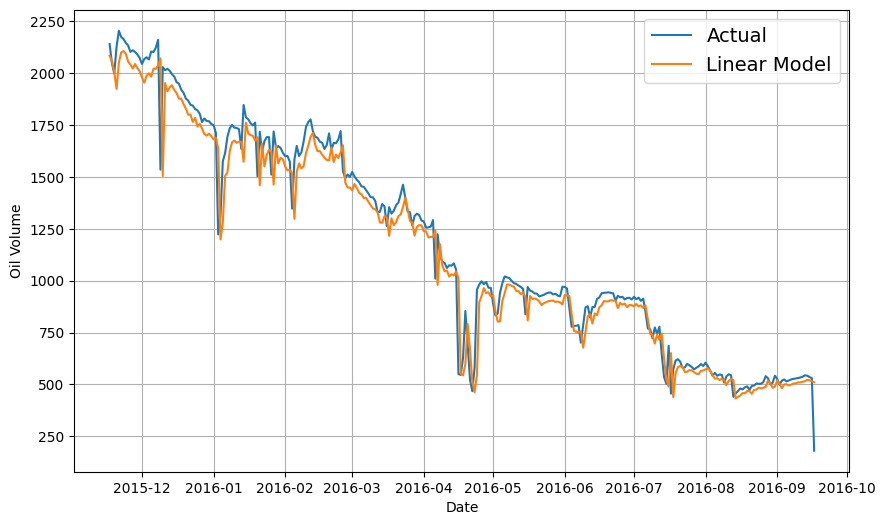

In [42]:
plt.figure(figsize=(10, 6))
plot_series(date_valid, x_valid, label="Actual")
plot_series(date_valid, lin_forecast, label="Linear Model")

plt.show()

In [43]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

66.415436

#  MLP

In [46]:
refresh()

window_size = 30

train_set = window_dataset(x_train, window_size)

model = Sequential([
            Dense(10, activation="relu", input_shape=[window_size]),
            Dense(10, activation="relu"),
            Dense(1)
        ])

lr_schedule = LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))

optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 1123.6078 - mae: 1124.1077
Epoch 2/100
85/85 [==============================] - 0s 4ms/step - loss: 651.7624 - mae: 652.2620
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 619.7546 - mae: 620.2542
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 601.8245 - mae: 602.3237
Epoch 5/100
85/85 [==============================] - 1s 5ms/step - loss: 590.0359 - mae: 590.5356
Epoch 6/100
85/85 [==============================] - 0s 4ms/step - loss: 573.8967 - mae: 574.3964
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 573.2772 - mae: 573.7760
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 541.7629 - mae: 542.2622
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 532.0974 - mae: 532.5967
Epoch 10/100
85/85 [==============================] - 0s 3ms/step - loss: 514.2001 - mae: 514.6990
Epoch 11/100
85/8

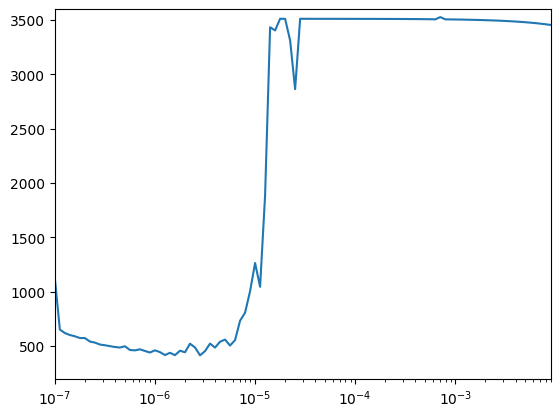

3526.37060546875

In [50]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 9e-3, 200, 3600])

plt.show()

max(history.history["loss"])

In [51]:
refresh()

window_size = 30

train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = Sequential([
            Dense(10, activation="relu", input_shape=[window_size]),
            Dense(10, activation="relu"),
            Dense(1)
        ])

optimizer = keras.optimizers.SGD(learning_rate=5e-6, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = EarlyStopping(patience=10)

model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
85/85 [==============================] - 1s 8ms/step - loss: 832.4487 - mae: 832.9482 - val_loss: 64.7672 - val_mae: 65.2608
Epoch 2/500
85/85 [==============================] - 1s 6ms/step - loss: 624.4766 - mae: 624.9763 - val_loss: 64.9021 - val_mae: 65.4011
Epoch 3/500
85/85 [==============================] - 1s 5ms/step - loss: 581.6130 - mae: 582.1127 - val_loss: 48.6356 - val_mae: 49.1349
Epoch 4/500
85/85 [==============================] - 1s 6ms/step - loss: 560.0151 - mae: 560.5148 - val_loss: 128.1376 - val_mae: 128.6375
Epoch 5/500
85/85 [==============================] - 1s 5ms/step - loss: 488.1148 - mae: 488.6145 - val_loss: 55.5176 - val_mae: 56.0145
Epoch 6/500
85/85 [==============================] - 1s 5ms/step - loss: 543.6833 - mae: 544.1826 - val_loss: 210.1546 - val_mae: 210.6546
Epoch 7/500
85/85 [==============================] - 1s 5ms/step - loss: 535.6169 - mae: 536.1169 - val_loss: 79.3988 - val_mae: 79.8967
Epoch 8/500
85/85 [==================

In [52]:
dense_forecast = model_forecast(
                    model,
                    oil_data[split_date - window_size:-1],
                    window_size)[:, 0]

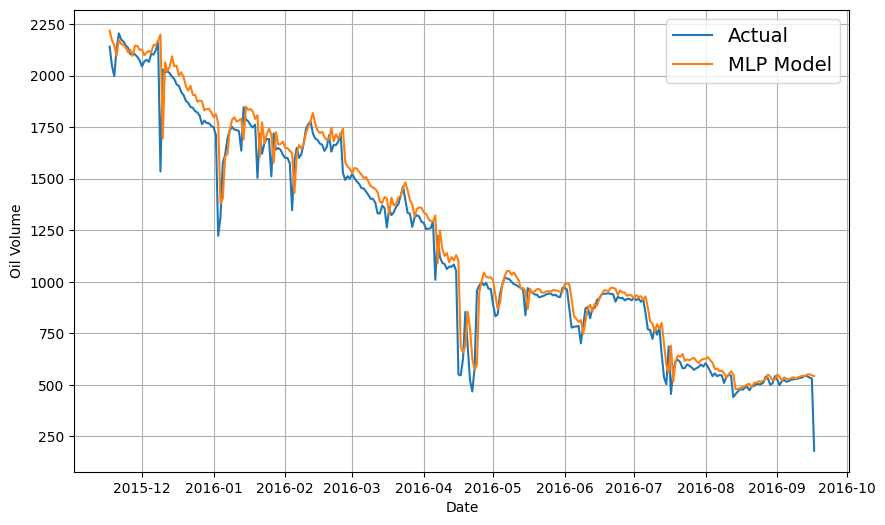

In [53]:
plt.figure(figsize=(10, 6))
plot_series(date_valid, x_valid, label="Actual")
plot_series(date_valid, dense_forecast, label="MLP Model")

plt.show()

In [54]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

59.534786

# RNN Model - LSTM

In [55]:
def sequential_window_dataset(series, window_size):
    
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    
    return ds.batch(1).prefetch(1)

In [56]:
refresh()

window_size = 30

train_set = sequential_window_dataset(x_train, window_size)

model = Sequential([
    
        LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(100, return_sequences=True, stateful=True),
        Dense(1)
        #Lambda(lambda x: x * 200.0)
    
        ])

learning_rate_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[learning_rate_schedule, reset_states])

Epoch 1/100
91/91 [==============================] - 7s 18ms/step - loss: 3515.8237 - mae: 3516.3118
Epoch 2/100
91/91 [==============================] - 2s 18ms/step - loss: 3515.8193 - mae: 3516.3074
Epoch 3/100
91/91 [==============================] - 2s 18ms/step - loss: 3515.8159 - mae: 3516.3040
Epoch 4/100
91/91 [==============================] - 2s 18ms/step - loss: 3515.8140 - mae: 3516.3010
Epoch 5/100
91/91 [==============================] - 2s 18ms/step - loss: 3515.8118 - mae: 3516.2996
Epoch 6/100
91/91 [==============================] - 2s 18ms/step - loss: 3515.8110 - mae: 3516.2986
Epoch 7/100
91/91 [==============================] - 2s 19ms/step - loss: 3515.8101 - mae: 3516.2966
Epoch 8/100
91/91 [==============================] - 2s 18ms/step - loss: 3515.8091 - mae: 3516.2957
Epoch 9/100
91/91 [==============================] - 2s 18ms/step - loss: 3515.8069 - mae: 3516.2942
Epoch 10/100
91/91 [==============================] - 2s 18ms/step - loss: 3515.8052 - mae:

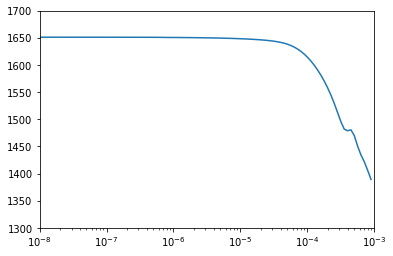

1389.3135986328125

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 1300, 1700])
plt.show()

min(history.history["loss"])

In [64]:
refresh()

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = Sequential([
                    
        LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(100, return_sequences=True, stateful=True),
        Dense(1),
        #Lambda(lambda x: x * 200.0)
        
        ])

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

reset_states = ResetStatesCallback()
model_checkpoint = ModelCheckpoint("my_checkpoint.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=50)

model.fit(train_set, epochs=500, validation_data=valid_set, 
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
91/91 [==============================] - 8s 33ms/step - loss: 3515.6526 - mae: 3516.1382 - val_loss: 1189.8130 - val_mae: 1190.3130
Epoch 2/500
91/91 [==============================] - 2s 19ms/step - loss: 3515.2739 - mae: 3515.7642 - val_loss: 1189.4089 - val_mae: 1189.9091
Epoch 3/500
91/91 [==============================] - 2s 19ms/step - loss: 3514.9006 - mae: 3515.3960 - val_loss: 1189.0178 - val_mae: 1189.5179
Epoch 4/500
91/91 [==============================] - 2s 19ms/step - loss: 3514.5447 - mae: 3515.0422 - val_loss: 1188.6425 - val_mae: 1189.1425
Epoch 5/500
91/91 [==============================] - 2s 22ms/step - loss: 3514.2075 - mae: 3514.7051 - val_loss: 1188.3016 - val_mae: 1188.8016
Epoch 6/500
91/91 [==============================] - 2s 19ms/step - loss: 3513.8979 - mae: 3514.3982 - val_loss: 1187.9817 - val_mae: 1188.4816
Epoch 7/500
91/91 [==============================] - 2s 19ms/step - loss: 3513.6082 - mae: 3514.1077 - val_loss: 1187.6742 - val_mae: 11

In [65]:
#load best model
model = keras.models.load_model("my_checkpoint.h5")

In [66]:
#forcast
rnn_forecast = model.predict(oil_data[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_date - 1:-1, 0]

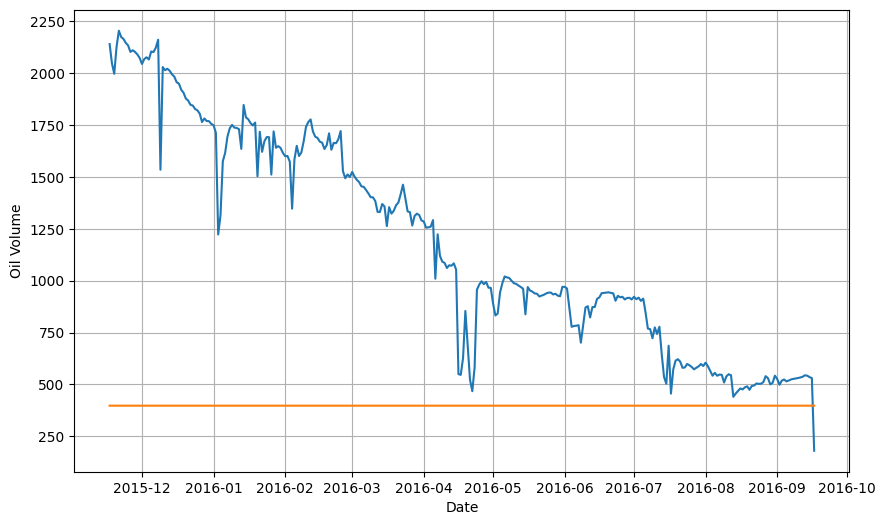

In [67]:
plt.figure(figsize=(10, 6))
plot_series(date_valid, x_valid)
plot_series(date_valid, rnn_forecast)

plt.show()

In [68]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

786.00555

#univariate

In [ ]:
# specify the window size
n_steps = 7

# split into samples
X, y = split_sequence(values, n_steps)

# reshape into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# define model
model = Sequential()

model.add(Input(shape=(X_train.shape[1],)))

In [ ]:
model.add(LSTM(100, activation='relu', kernel_initializer='he_normal'))

In [ ]:
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# fit the model
model.fit(X_train, y_train, epochs=350, batch_size=32, verbose=2, validation_data=(X_test, y_test))

# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, sqrt(mse), mae))

# make a prediction


In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())